CSS 610 Spring 2025 L. Teinfalt ABM of Employment Migration
Notebook for Running Simulations of Agent-Based Models 
Requires mesa library to be installed 
Last Updated: 05/14/2025

In [23]:
# CSS 610 Spring 2025 L. Teinfalt ABM of Employment Migration
# Notebook for executing MigrationModel ABM and ACFMigrationModel
# Required libraries: pip install mesa

import pandas as pd
import mesa
from mesa.space import SingleGrid
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
import random
from agents import ABP, ACFAgent
from model import MigrationModel, ACFMigrationModel, ACFMigrationModel2

In [24]:
def employed_3d_scatter_plot(model, ax, agent_status="employed"):
    """
    Creates a 3D scatter plot of agent density (employed or unemployed)
    calculated over Moore neighborhoods.

    Args:
        model (MigrationModel): The current Mesa model instance.
        agent_status (str, optional):  "employed" or "unemployed".
                                      Determines which agents are counted.
                                      Defaults to "employed".

    Returns:
        Any: A Matplotlib figure containing the 3D scatter plot.
    """

    if agent_status not in ["employed", "unemployed"]:
        raise ValueError("agent_status must be 'employed' or 'unemployed'")

    # 1. Create a grid to store the density
    grid_width = model.grid.width
    grid_height = model.grid.height
    density_grid = np.zeros((grid_width, grid_height))

    # 2. Populate the density grid, considering Moore neighborhood and agent status
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            neighborhood = model.grid.get_neighborhood(
                (x, y), moore=True, include_center=True
            )  # Get Moore neighborhood

            total_agents_of_status = 0
            neighborhood_size = len(neighborhood)

            for cell in neighborhood:
                agents_in_cell = model.grid.get_cell_list_contents(cell)
                if agent_status == "employed":
                    total_agents_of_status += sum(
                        1 for agent in agents_in_cell if agent.is_employed
                    )
                elif agent_status == "unemployed":
                    total_agents_of_status += sum(
                        1 for agent in agents_in_cell if not agent.is_employed
                    )

            # Calculate the average density in the neighborhood
            density_grid[x, y] = (
                total_agents_of_status / neighborhood_size
                if neighborhood_size > 0
                else 0
            )

    # 3. Prepare data for plotting
    x_coords, y_coords = np.meshgrid(range(grid_width), range(grid_height))
    x_coords = x_coords.flatten()
    y_coords = y_coords.flatten()
    z_coords = density_grid.flatten()

    # 4. Create the 3D plot
    #fig = plt.figure(figsize=(8, 6))
    #ax = fig.add_subplot(111, projection="3d")
    if agent_status == "employed":
      ax.scatter3D(x_coords, y_coords, z_coords, color="#8B4513", marker="o")
    else: ax.scatter3D(x_coords, y_coords, z_coords, color="#556B2F", marker="^")

    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax_label = f"Agent Density ({agent_status}, Neighborhood Avg)"
    ax.set_zlabel(ax_label)
    ax.set_title(f"3D Scatter Plot of {ax_label}")
    #plt.show()

   #return fig  # Optionally return the figure



In [25]:
#2D Density contour visualization module for showing density of employed and unemployed agents
import seaborn as sns
from scipy.ndimage import gaussian_filter


def agent_density_contour_seaborn(
    model,
    ax,
    agent_status="employed",
    smooth=True,
    cmap = sns.cubehelix_palette(light=1, as_cmap=True),
    contour_levels=10,
    contour_color="#ba8961", #contour line color
):
    """
    Generates a contour plot of agent density using Seaborn with improved alignment.

    Args:
        model (MigrationModel): The Mesa model instance.
        agent_status (str, optional): "employed" or "unemployed".
        smooth (bool, optional): Apply Gaussian smoothing.
        cmap (str, optional): Colormap for the heatmap.
        contour_levels (int or array-like, optional): Contour levels.
        contour_color (str, optional): Color of the contour lines.
    """

    if agent_status not in ["employed", "unemployed"]:
        raise ValueError("agent_status must be 'employed' or 'unemployed'")

    density_grid = np.zeros((model.grid.width, model.grid.height))
    for x in range(model.grid.width):
        for y in range(model.grid.height):
            agents_in_cell = model.grid.get_cell_list_contents((x, y))
            if agent_status == "employed":
                density_grid[x, y] = sum(1 for a in agents_in_cell if a.is_employed)
            elif agent_status == "unemployed":
                density_grid[x, y] = sum(1 for a in agents_in_cell if not a.is_employed)

    if smooth:
        density_grid = gaussian_filter(density_grid, sigma=1)


    # 1. Heatmap with Correct Extent
    extent = [0, model.grid.width, 0, model.grid.height]  # Define extent for heatmap
    try:
        sns.heatmap(
            density_grid.T,
            cmap=cmap,
            #extent=extent,
            cbar_kws={"label": f"{agent_status.capitalize()} Agent Density"},
            ax=ax,  # Pass the axes to heatmap
            vmin=0,  # Ensure consistent color scale
            vmax=np.max(density_grid) if density_grid.size > 0 else 1,  # Handle empty grid
        )
    except Exception as e:
        print(f"Error in heatmap: {e}")
        sns.heatmap(
            density_grid.T,
            cmap=cmap,
            cbar_kws={"label": f"{agent_status.capitalize()} Agent Density"},
            ax=ax,  # Pass the axes to heatmap
            vmin=0,  # Ensure consistent color scale
            vmax=np.max(density_grid) if density_grid.size > 0 else 1,  # Handle empty grid
        )

    # 2. Contour Plot with Matching Extent
    x = np.arange(0, model.grid.width)  # Align x-coordinates with heatmap edges
    y = np.arange(0, model.grid.height)  # Align y-coordinates with heatmap edges
    X, Y = np.meshgrid(x, y)
    try:
        contour = ax.contour(
            X, Y, density_grid.T, levels=contour_levels, colors=contour_color, extent=extent
        )  # Use the same extent
        ax.clabel(contour, inline=True, fontsize=8)  # Add labels to contour lines
    except Exception as e:
        print(f"Error in contour: {e}")
        contour = ax.contour(
            X, Y, density_grid.T, levels=contour_levels, colors=contour_color
        )  # Use the same extent
        ax.clabel(contour, inline=True, fontsize=8)  # Add labels to contour lines

    ax.set_title(f"{agent_status.capitalize()} Agent Density Contour")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Y Coordinate")


    return ax



In [26]:

# Function to plot histogram called by run_one_model or run_two_models
def plot_histogram(employed_counts, unemployed_counts):
    plt.figure(figsize=(8, 6))
    
    # Plot histogram for  agents
    sns.histplot(employed_counts, bins=20, kde=False, label="Employed Agents", color="#F1BB7B", alpha=0.7)
    sns.histplot(unemployed_counts, bins=20, kde=False, label="Unemployed Agents", color="#2E8B57", alpha=0.7)
    
    # Add labels and title
    plt.xlabel("Agent Count")
    plt.ylabel("Frequency")
    plt.title("Histogram of Employed and Unemployed Agents")
    plt.legend(loc="upper center")
    plt.show()


In [27]:
def plot_wage_heatmap(wage_field):
    """
    Generates a 2D heatmap of the wage field using Seaborn.

    Args:
        wage_field (numpy.ndarray): A 2D numpy array representing the wage field.
    """
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(wage_field, cmap="viridis")  # Use a heatmap
    plt.title("Wage Field Heatmap")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

In [28]:
#Called from run_one_model and run_two_models
def model_output(model):
    cmap = sns.light_palette("#F1BB7B", as_cmap=True) #color for employed agents
    cmap1 = sns.light_palette("#2E8B57", as_cmap=True) #color for unemployed agents

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), subplot_kw={'projection': '3d'}) 

    # Pass the axes to the plotting function
    employed_3d_scatter_plot(model, ax1, agent_status="employed")
    employed_3d_scatter_plot(model, ax2, agent_status="unemployed")
    plt.show()  # Show the plot


    #Seaborn Density Contour Map
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    #ACF Agents
    agent_density_contour_seaborn(model, ax1, agent_status="employed", contour_levels=10, cmap=cmap)
    agent_density_contour_seaborn(model, ax2, agent_status="unemployed", contour_levels=10, cmap=cmap1)

    plt.tight_layout()
    plt.show()

In [29]:
#Module to execute on ABM one at a time accepts "ACF" or "ABP" for ABM input and numerical value for num_steps
#Called from main
def run_one_model(ABM, num_steps):
    """
    Run one model separately
    """
    #initialize the data structures for counts
    employed_ratios = []
    unemployed_ratios = []
    steps = []
    employed_counts = []
    unemployed_counts = []

    if ABM == "ACF":
        model = ACFMigrationModel(num_agents=320, width=20, height=20) 
    elif ABM == "ABP":
        model = MigrationModel(num_agents=320, width=20, height=20)
    
    print("*************Running one model at a time:", ABM)
    for j in range(num_steps):
      model.step()
      employed_count = sum(1 for a in model.agents if a.is_employed)
      unemployed_count = sum(1 for a in model.agents if not a.is_employed)
      employed_counts.append(employed_count)
      unemployed_counts.append(unemployed_count)
      total_agents = model.num_agents
      employed_ratio = employed_count / total_agents if total_agents > 0 else 0
      unemployed_ratio = unemployed_count / total_agents if total_agents > 0 else 0
      steps.append(j + 1)
    
    print("*************One model run finished running**************")
    plot_histogram(employed_counts, unemployed_counts)
    plot_wage_heatmap(model.wage_field)
    model_output(model)
    return model


In [30]:
#Module to execute on two ABMs in sequence. Input parameter is number of steps to run the simulation
#First to execute is MigrationModel which instantiates ABP Agents in the Agents.py class
#Final wage field and locations are extracted when MigrationModel completes
#Second to execute is ACFMigrationModel2 that instantiates ACF Agents in the Agents.py class
#Called from main
#Calls model_output and 

def run_two_models(num_steps):
    """
    Runs two models sequentially
    """

    employed_ratios = []
    unemployed_ratios = []
    steps = []
    employed_counts = []
    unemployed_counts = []

    # 1. Run the first model (MigrationModel)
    model1 = MigrationModel(num_agents=320, width=20, height=20)
    for i in range(num_steps):
        model1.step()
        employed_count = sum(1 for a in model1.agents if a.is_employed)
        unemployed_count = sum(1 for a in model1.agents if not a.is_employed)
        employed_counts.append(employed_count)
        unemployed_counts.append(unemployed_count)
        total_agents = model1.num_agents
        employed_ratio = employed_count / total_agents if total_agents > 0 else 0
        unemployed_ratio = unemployed_count / total_agents if total_agents > 0 else 0
        steps.append(i + 1)
    
    # 2. Extract output from the first model
    final_agent_locations = [(agent.pos[0], agent.pos[1]) for agent in model1.agents if agent is not None]
    final_wage_field = model1.wage_field
    print("Model 1: Migration Model with ABP Agents finished running.")
    
    #Running output and visualization from first model -- Commented out to reduce redundancy
    #plot_histogram(employed_counts, unemployed_counts)
    #plot_wage_heatmap(model1.wage_field)
    #model_output(model1)

    # Reset the data structures
    employed_ratios = []
    unemployed_ratios = []
    steps = []
    employed_counts = []
    unemployed_counts = []
    
    # 3.  Run the second model (ACFMigrationModel)
    model2 = ACFMigrationModel2(num_agents=320, width=20, height=20, initial_agent_locations=final_agent_locations, initial_wage_field=final_wage_field) #Pass the output from model 1 to model 2
    for j in range(num_steps):
        model2.step()
        employed_count = sum(1 for a in model2.agents if a.is_employed)
        unemployed_count = sum(1 for a in model2.agents if not a.is_employed)
        employed_counts.append(employed_count)
        unemployed_counts.append(unemployed_count)
        total_agents = model2.num_agents
        employed_ratio = employed_count / total_agents if total_agents > 0 else 0
        unemployed_ratio = unemployed_count / total_agents if total_agents > 0 else 0
        steps.append(i + 1)

    print("Model 2: ACF Migration Model with ACF Agents finished running.")
    plot_histogram(employed_counts, unemployed_counts)
    plot_wage_heatmap(model2.wage_field)
    model_output(model2)
    return model2


Run Active Brownian Particles Agents Using Migration Model
*************Running one model at a time: ABP
*************One model run finished running**************


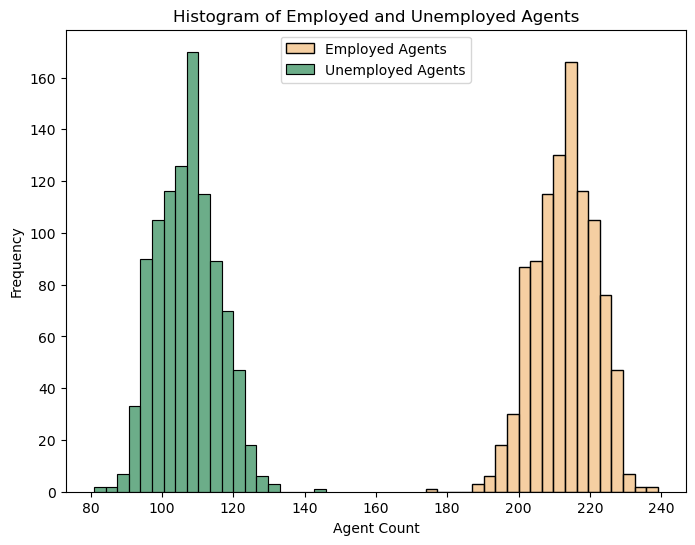

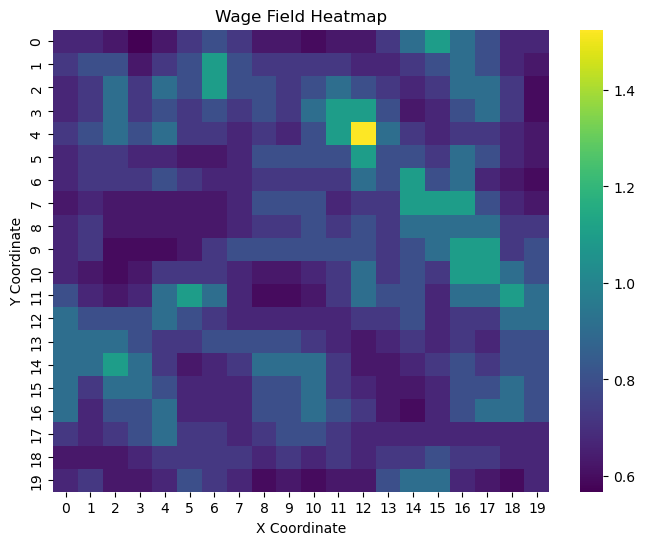

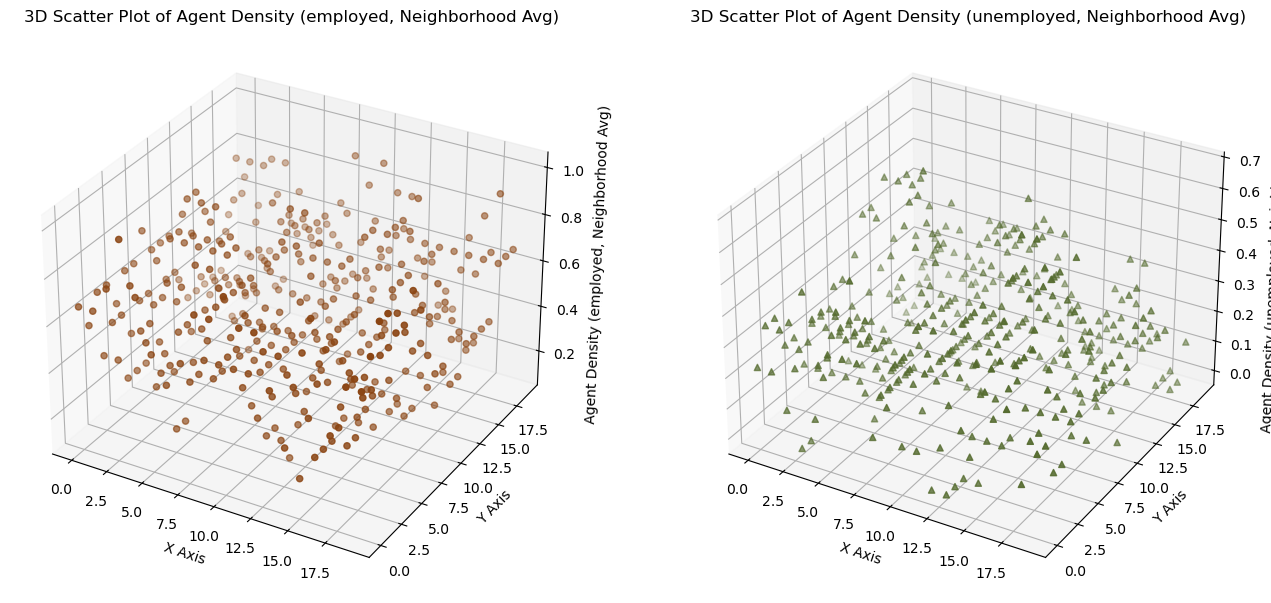

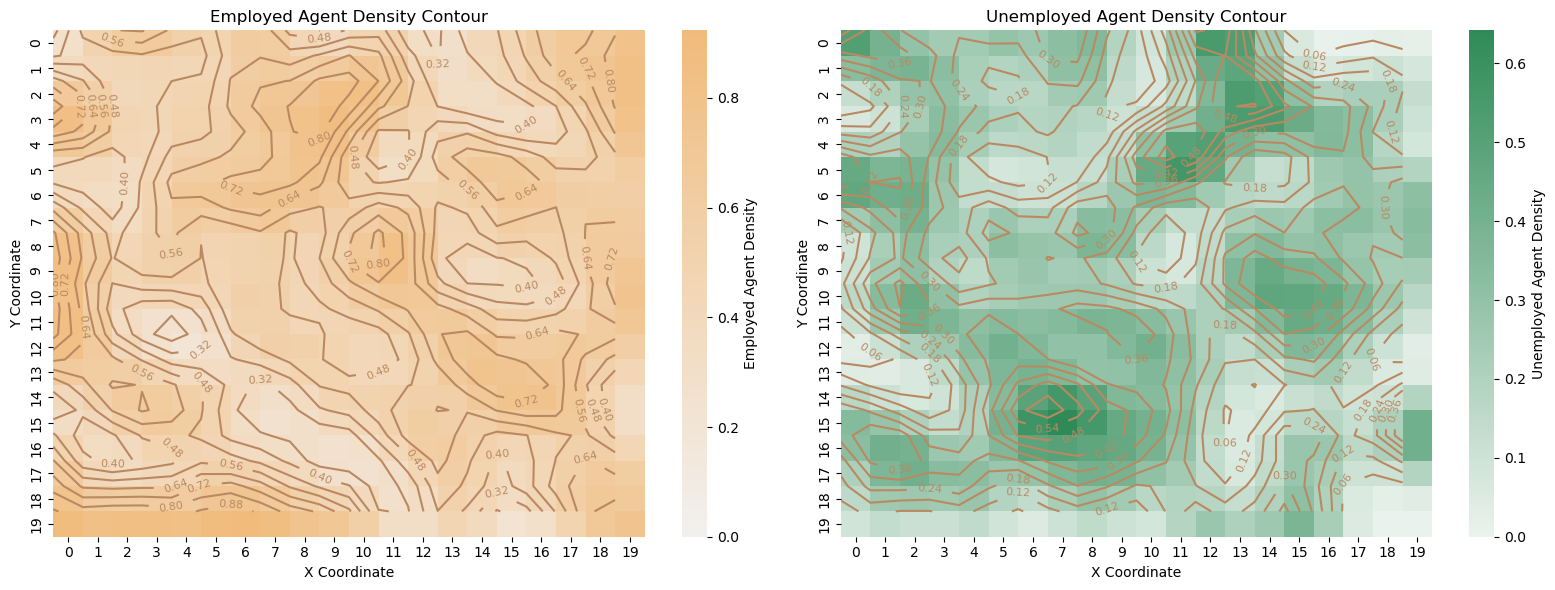

ACF Agents using ACF Migration Model
*************Running one model at a time: ACF
*************One model run finished running**************


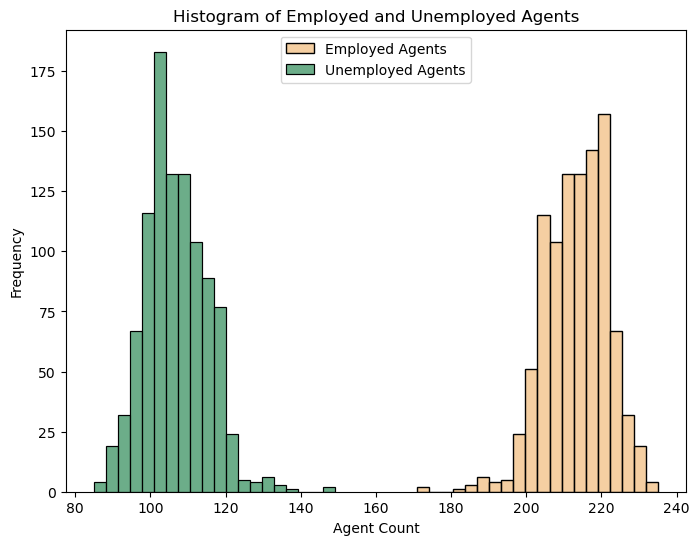

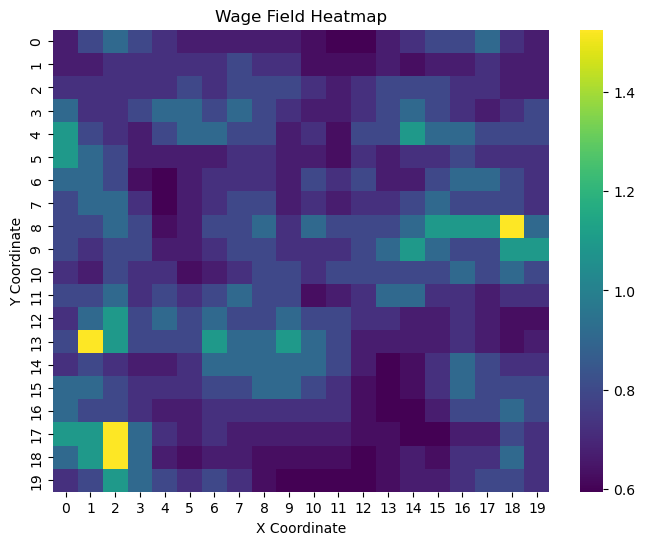

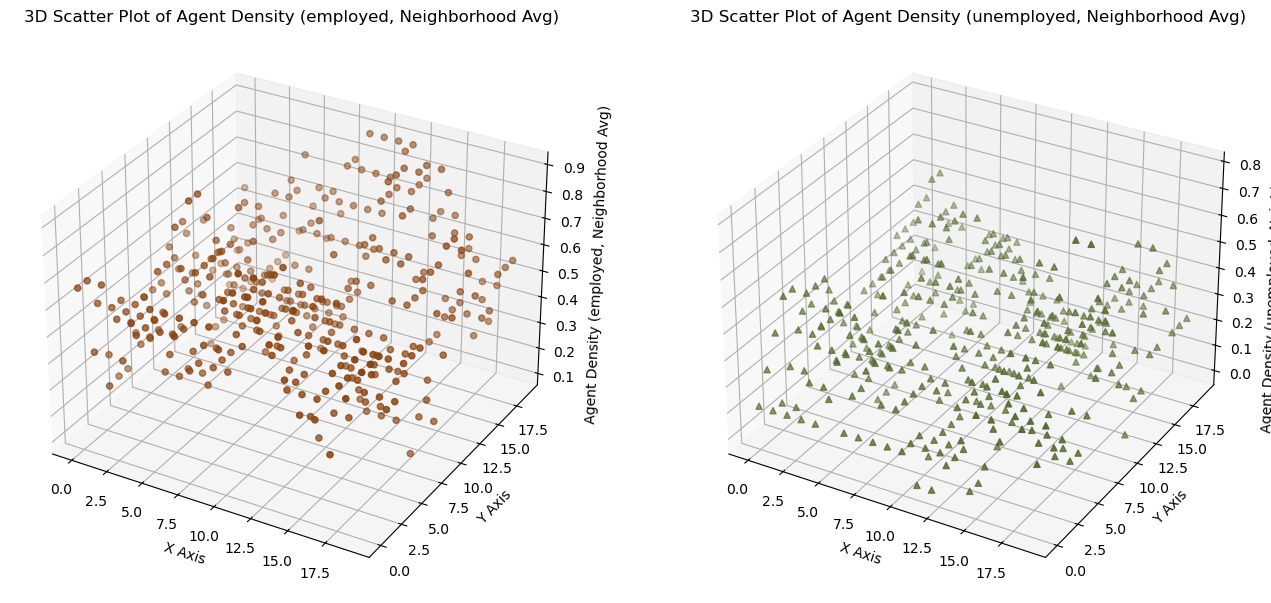

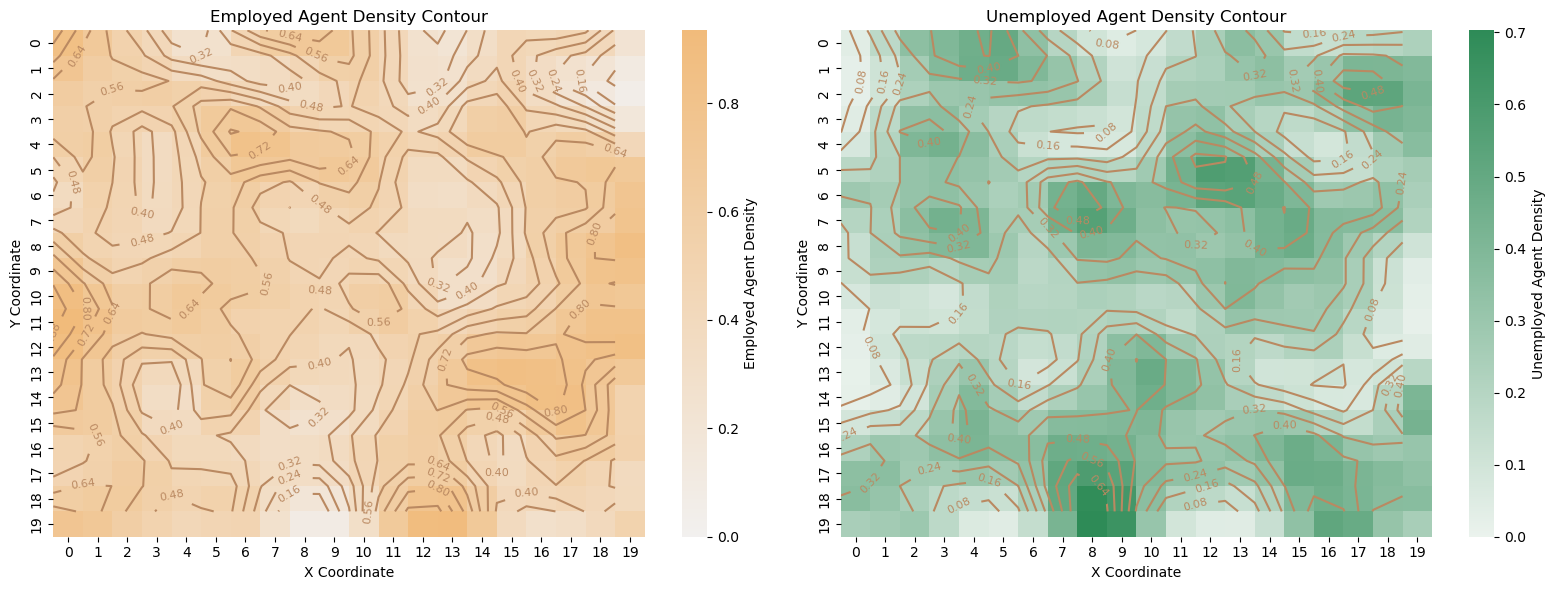

In [32]:
#Main function that executes one model at a time running 1000 steps (Experiments 1 and 2)
#Produces visualizations for comparison
#Simulation runs num_steps time steps

if __name__ == "__main__":
    #Run one model at a time
    print("Run Active Brownian Particles Agents Using Migration Model")
    model = run_one_model("ABP", num_steps = 1000)

    print("ACF Agents using ACF Migration Model")
    model = run_one_model("ACF", num_steps = 1000)



Running two models: Migration Model using ABP Agents then ACFMigrationModel using ACF Agents
Model 1: Migration Model with ABP Agents finished running.
Model 2: ACF Migration Model with ACF Agents finished running.


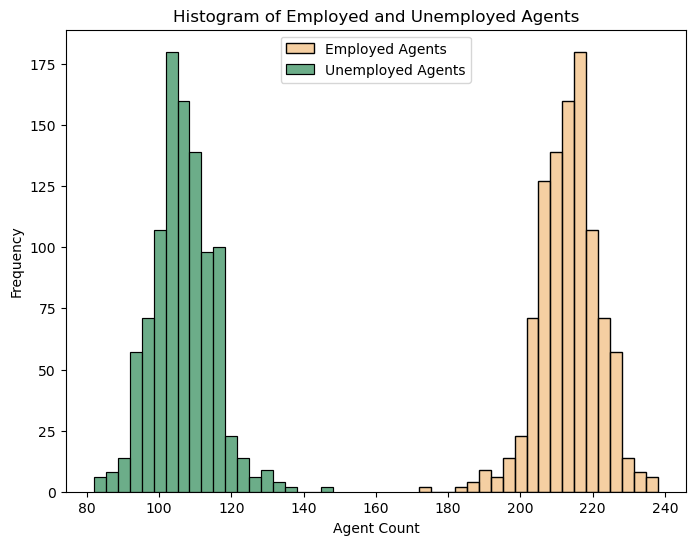

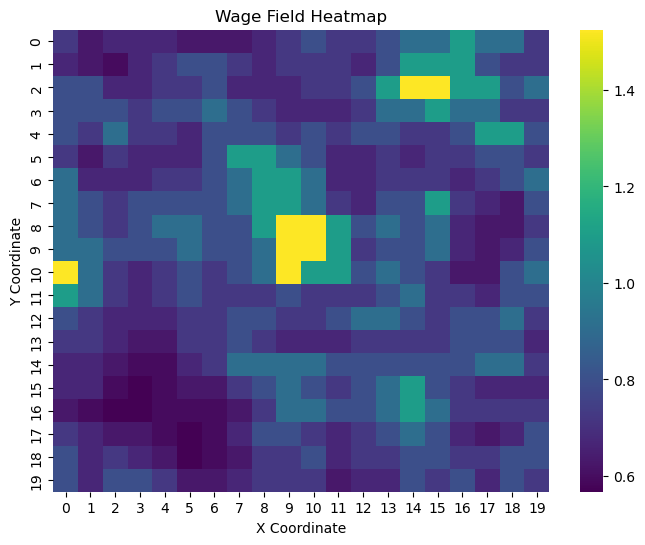

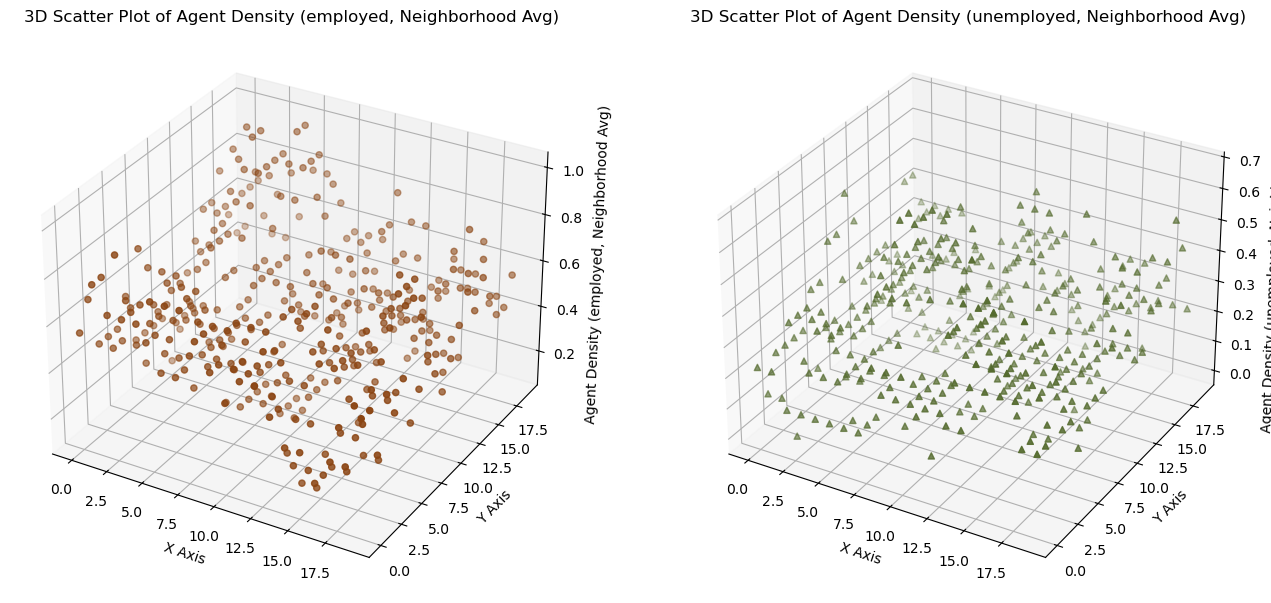

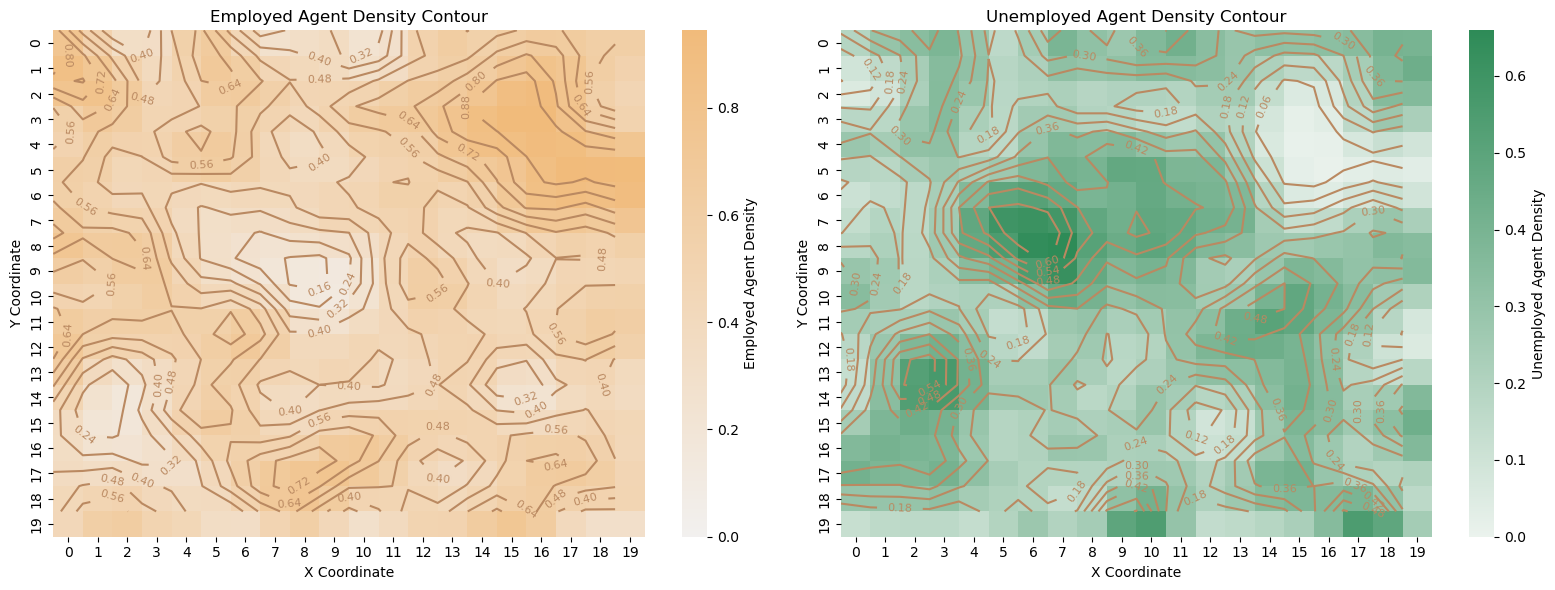

In [43]:
#Main function that two models in sequence. Sequence is harded coded to run MigrationModel first and then ACFMigrationModel
#Simulation runs num_steps time steps

if __name__ == "__main__":
    #Run two models in sequence
    print("Running two models: Migration Model using ABP Agents then ACFMigrationModel using ACF Agents")
    model = run_two_models(num_steps = 1000)